**Background**

Brain recordings, such as EEG and fMRI seek to characterize brain activity and connectivity. A complete understanding of the braib dynamics can lead to a much better understanding of brain pathologies and can help direct new paths into AI. Recordings seek to determine functional connectivity between the different hierarchial organizations of the brain, and this ideal representation of the brain is very important, because it can be directly mapped to brain physiology and it can directly inform us of the dynamics residing in the brain structure. 

Specifically, $ \begin{equation} S = M(E(B(N,I,t))) \end{equation}$ , where S is our recorded signal, B is the functional representation of the brain, dependent on N, the brain network, I, the input to the brain, and t, time. E is representing the mapping from the functional representation to the actual electrophysiology that encodes that information. M is representing the mapping from brain electrophysiology to the measurements achieved by recording devices. 

directed Brain Network $ \begin{equation} N = (\vec{v},\vec{e}) \end{equation}$, where v correspond to vertice states, and e correspond to edge functions between vertices. v is multidimensional, can represent many hierarchial levels in the brain, such as neurons, nerve bundles, and whole regions. For neurons, the state could take into many factors, for example, location, topology of the neuron, phase/frequency of firing, number of synaptic vesicles etc. 

Brain Dynamics B: $ \begin{equation} \dot{v_{i}} = g(I) + \sum_{e \in N}{e(v_{j},v_{i},t)} \end{equation}$

\*Note that there can be self directed loops where edge function = $ \begin{equation} e(v_{i},t) \end{equation}$

The Input signal can encapsulate input signal from the environment and internal signaling. Signals from the environement can be more directly measured (visual cues, sensory features etc.) and internal signaling is less direct, but both contain some noise and lost information.

Electrophysiology E(B) maps the network state into a corresponding voltage density topology. Several electrophysiology models already exist to predict mapping of brain state to electrophysiology.

M(E) is takes the measurements from the eletrophysiology. Almost total information is known about M, since it's fairly easy to measure quantities about M (location of electrodes, orientation etc.) and there is much prior information on M (hardware features, effects of filtering, postprocessing signal etc.). However this is where noise gets introduced, as devices can pick up un extraneuous or faulty information sources. 

Since the mapping from the functional brain to electrophysiology is fairly direct, and the functional network intrinsically contains much of the information of the brain system, the general Bayesian problem is as follows:

*Given S,I, find N.*

However, this is a very hard problem to solve, as S and I are relatively low dimensional signals compared to N. This problem can be reworded into:

*Given S,I, find N' where arg min C(N,N')* 

C is our cost function associated with our predicted and actual N , which can encapsulate closeness of behavior of the two systems. Since biological mechanisms are usually repetitive and fractal-like, giving rise to complex structures with relatively simple rulesets and the brain can be globally modulated by input signals such as drugs, DBS, and rTMS, there may be some low dimensional features that can be extracted from S that can be used to predict the behavior of N to relatively high degree.

There already exist multitudes of signal features that the current literature utilizes to ascertain certain features of N, but efficacy of these features to predict functional behavior is quantitaively uncertain, and should be studies further to determine relations between the detected features and underlying brain network behavior. Underlied here is a path to quantitavely determine upper bounds on these features in describing functional network behavior.

A simple, ideal brain network B(N) with I = 0, and the network being time-invariant, was contructed. Then E was assumed to be identity functions, M was assumed to be a linear function and S was the actual signal from the time series of $ \begin{equation} \vec{v} \end{equation}$. Several measures curently used in the literatrure were then tested in a Monte Carlo simulation to get upper bounds of the efficacy. The constructed model is as follows:

$ \begin{equation}
\dot{v_{i}} = g(v_{i}) + \sum_{e \in N}{f(v_{j},v_{i})}
\end{equation}$

$ \begin{equation}
S = M \vec{v} + N
\end{equation}$
, where N is noise

Network: All-to-All (K), Small-World (SW), Preferential Attachment (BA), Modular (M)

**Correlation Measures**

CFC: PPC, AAC, PAC

Coherence: CTC, PLV

Spectral: RDP, Edge, Entropy, Moment

Nonlinear: Correlation Dimension/Saturation, Largest Lyapunov exponent, Kolmogorof entropy

Mutual Entropy: CMI, AMI

Connectivity Measures: TE, GCI, PLI, Pairwise Phase Consistency, GC, DT, PDC

In [2]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import cmath as c

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [132]:
class Model:
    def __init__(self, G, x, h, f, M, N, dt = .05):
        self.G = G #Graph representation of network
        self.x = x #states
        self.h = h #node function
        self.f = f #coupling function
        self.M = M #measurement matrix
        self.N = N #Variance for Gaussian noise
        self.y = self.linear_measure() #measurement vectors
        self.t = 0 #time
        self.dt = dt #time step
        
        #checks
        if len(self.x) == 0:
            raise ValueError('self.x can\'t have less than one state')
        if len(self.x) != nx.number_of_nodes(self.G):
            raise ValueError('length of self.x must match number of nodes')
        if len(self.x) != len(self.M):
            raise ValueError('length of self.x must match number of nodes')
        
    #state derivative
    def dev(self,phase):
        dev = np.matrix(np.zeros(len(self.x))).T      
        for i in range(1,len(self.x)):
            sumEdge = 0
            if self.G[i]:
                for j in self.G[i]:
                    sumEdge += self.f(self.x[i,-1],self.x[(j-1),-1])
            dev[i] = self.h(self.x[i,-1]) + sumEdge
        return dev
            
    #linear measurement
    def linear_measure(self):
        return self.M * self.x[:,-1] + np.matrix(np.random.normal(0,self.N,len(self.x))).T
    
    #euler method approximation of behavior
    def euler_step(self):
        new_state = self.x[:,-1] + self.dev(self.x[:,-1])*self.dt
        self.t += self.dt
        self.x = np.hstack((self.x,new_state))
        self.y = np.hstack((self.y,self.linear_measure()))
       
    #runge-Kutta approximation of behavior
    def runge_kutta_step(self):
        k1 = self.dev(self.x[:,-1])*self.dt
        k2 = self.dev(self.x[:,-1]+ .5*k1)*self.dt
        k3 = self.dev(self.x[:,-1]+ .5*k2)*self.dt
        k4 = self.dev(self.x[:,-1]+ k3)*self.dt
        new_state = self.x[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        self.t += self.dt
        self.x = np.hstack((self.x,new_state))
        self.y = np.hstack((self.y,self.linear_measure(new_state)))
    
    #time step function
    def step(self):
        self.euler_step()
        
    #runs model and stores states
    def run(self,T):
        for ts in range(0,int(T/self.dt)):
            self.step()
            
    #clears all states exept initial
    def clear_run(self):
        self.x = self.x[:,0]
        self.y = self.y[:,0]

In [219]:
#Create specific networks
n = 10

K = nx.complete_graph(n)
SW = nx.watts_strogatz_graph(n, k = 2, p = .1)
BA = nx.barabasi_albert_graph(n, m = 2)

In [198]:
#Initialization
x = np.matrix([10,1,10,1,1,10]).T

nodes = [1,2,3,4,5,6]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from([(1,2),(2,3),(1,6),(1,3),(3,4),(4,5),(4,6),(5,6)])

def h(x):
    return 0
def f(x,y):
    return y-x

M = np.identity(6)
N = .1

model = Model(G,x,h,f,M,N)
model.run(T = 10)

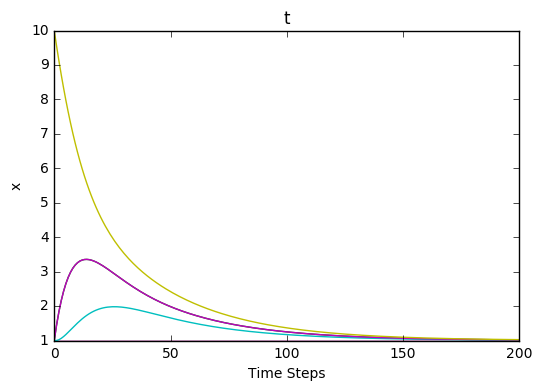

In [193]:
#Visualization Tools

def state_course(states):
    plt.figure()
    plt.plot(states.T)
    plt.xlabel('Time Steps')
    plt.ylabel('x')
    plt.title('t')
    plt.show()
    
def spectrogram(signal, sr = int(1/model.dt)):
    f, t, s = sig.spectrogram(signal, sr)
    plt.pcolormesh(t, f, s)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.show()

def PSD(signal, sr = int(1/model.dt)):
    f, Pxx = sig.welch(signal, sr)
    plt.semilogy(f, Pxx)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    
state_course(model.x)
#n = 1
#spectrogram(model.y[n,:].tolist()[0])
#PSD(model.y[n,:].tolist()[0])

In [200]:
#runs functions across all signals
def cross_func(sig, func):
    M = np.zeros((len(sig), len(sig)))
    for i in range(len(sig)):
        for j in range(len(sig)):
            M[i,j] = func(sig[i,:],sig[j,:])
    return M

In [202]:
#coherence
coh = sig.coherence

TypeError: 'function' object is not iterable

In [19]:
#PLV
def phase_locking_value(x,y):
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

matrix([[ 0.,  0.,  0.]])